In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tiingo[pandas]
from IPython.display import clear_output
clear_output(wait=True)
print("Installed packages Successfullyy!")

Installed packages Successfullyy!


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Flatten
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
# from tf.keras.metrics import MeanAveragePrecisionMetric

%matplotlib inline

# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.style.use('fivethirtyeight')

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# **Setting up Tiingo Client**

In [3]:
from tiingo import TiingoClient
config = {}
config['session'] = True
config['api_key'] = "44c3cbbc4115125fe0f7012c67b29d10f0be5a00"

client = TiingoClient(config)

In [4]:
df = client.get_dataframe('BTCUSD',
                          startDate='2017-01-01',
                          endDate='2023-06-18'
                          )

# **Preprocessing**

In [5]:
# Getting range of dates
from datetime import timedelta, date
# dates=[]
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2017, 1, 1)
end_dt = date(2023, 6, 18)
def getDateRange(start_dt, end_dt):
  dates = []
  for dt in daterange(start_dt, end_dt):
      dates.append(dt.strftime("%Y-%m-%d"))
  return dates
dates = getDateRange(start_dt, end_dt)

In [6]:
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2017-01-02 00:00:00+00:00,997.75,1034.355016,960.530000,999.873057,8682.177030,997.75,1034.355016,960.530000,999.873057,8682.177030,0.0,1.0
2017-01-03 00:00:00+00:00,1012.54,1042.005416,990.010000,1019.000001,9507.151213,1012.54,1042.005416,990.010000,1019.000001,9507.151213,0.0,1.0
2017-01-04 00:00:00+00:00,1035.24,1147.982587,999.990000,1037.097956,12891.887764,1035.24,1147.982587,999.990000,1037.097956,12891.887764,0.0,1.0
2017-01-05 00:00:00+00:00,1114.92,1159.095335,881.982128,1133.942221,31165.394385,1114.92,1159.095335,881.982128,1133.942221,31165.394385,0.0,1.0
2017-01-06 00:00:00+00:00,1004.74,1136.720000,870.029769,998.857874,42266.879034,1004.74,1136.720000,870.029769,998.857874,42266.879034,0.0,1.0


In [7]:
df.tail()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2023-06-15 00:00:00+00:00,25572.803017,25749.796379,24753.996910,25124.730920,22165.136015,25572.803017,25749.796379,24753.996910,25124.730920,22165.136015,0.0,1.0
2023-06-16 00:00:00+00:00,26330.709227,26490.523078,25147.237849,25572.619646,19352.290279,26330.709227,26490.523078,25147.237849,25572.619646,19352.290279,0.0,1.0
2023-06-17 00:00:00+00:00,26509.653006,26790.689432,26170.115626,26331.821882,8851.712221,26509.653006,26790.689432,26170.115626,26331.821882,8851.712221,0.0,1.0
2023-06-18 00:00:00+00:00,26338.200568,26694.939132,26249.027233,26510.588655,6423.388291,26338.200568,26694.939132,26249.027233,26510.588655,6423.388291,0.0,1.0
2023-06-19 00:00:00+00:00,26839.689811,27042.715609,26255.235666,26338.076829,12097.978510,26839.689811,27042.715609,26255.235666,26338.076829,12097.978510,0.0,1.0


In [8]:
df.shape

(2360, 12)

In [9]:
closeprice=[]
def close(df):
  closeprice = []
  for i in range(df.shape[0]):
    closeprice.append(df['close'][i])
  # print(len(closeprice))
  return closeprice
closeprice = close(df)

In [10]:

def newTestData(dates, closeprice):
  new_df=pd.DataFrame()
  new_df['Date']=dates
  new_df['Close']=closeprice

  return new_df
df = newTestData(dates, closeprice)
print(len(dates))
df.head()

2360


,Date,Close
0,2017-01-01,997.75
1,2017-01-02,1012.54
2,2017-01-03,1035.24
3,2017-01-04,1114.92
4,2017-01-05,1004.74


Text(0, 0.5, 'Close Price (USD)')

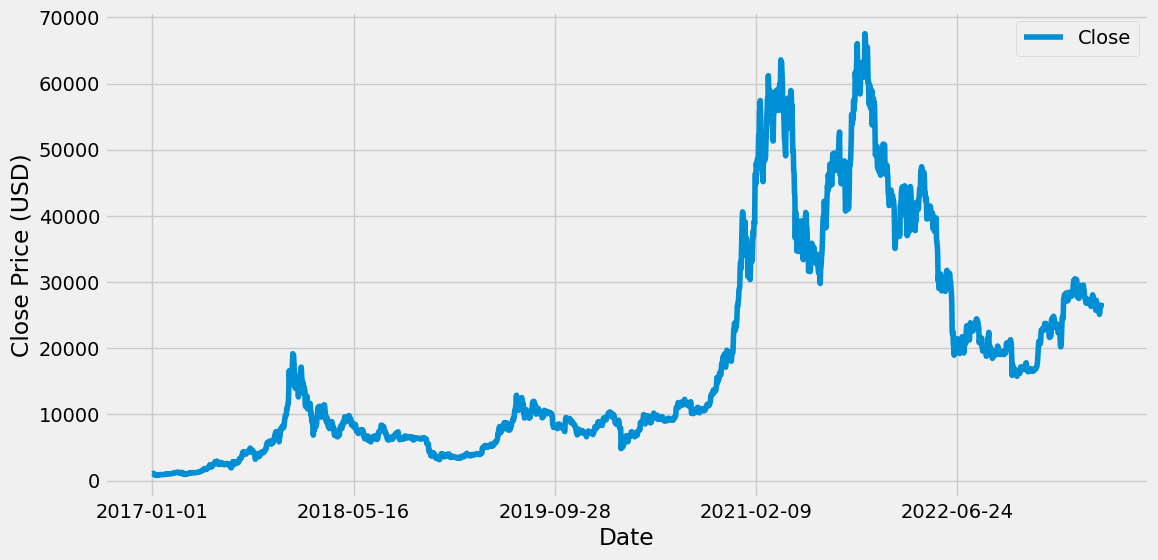

In [11]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# **Normalization**

In [12]:
scaler = MinMaxScaler()
def normalization(df):
  # scaler = MinMaxScaler()
  close_price = df.Close.values.reshape(-1, 1)
  scaled_close = scaler.fit_transform(close_price)
  print(scaled_close.shape)
  return scaled_close

In [24]:
scaled_close = normalization(df)
scaled_close.shape
# scaled_close = scaled_close[:-1]
# print(scaled_close.shape)

(2360, 1)


(2360, 1)

In [25]:
import numpy as np
from scipy.ndimage import shift

decoderInputs = scaled_close[::-1]
print(decoderInputs.shape)
decoderInputs = decoderInputs[:-1]
decoderInputs = decoderInputs[::-1]
scaled_close = scaled_close[:-1]
print(decoderInputs.shape)
decoderInputs

(2360, 1)
(2359, 1)


array([[0.00350423],
       [0.00384429],
       [0.00503793],
       ...,
       [0.38546274],
       [0.38289431],
       [0.39040685]])

In [26]:
print(scaled_close.shape)
scaled_close

(2359, 1)


array([[0.00328267],
       [0.00350423],
       [0.00384429],
       ...,
       [0.38278208],
       [0.38546274],
       [0.38289431]])

In [27]:
SEQ_LEN = 101
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    # print(np.array(d).shape)
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
def preprocessDecoderInput(decoderInputs, seq_len, train_split):
    data = to_sequences(decoderInputs, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.987)
X_train_Decoder, y_train_Decoder, X_test_Decoder, y_test_Decoder = preprocessDecoderInput(scaled_close, SEQ_LEN, train_split = 0.987)

In [28]:
X_train.shape

(2228, 100, 1)

In [29]:
X_test.shape

(30, 100, 1)

In [30]:
y_train.shape

(2228, 1)

In [31]:
y_test.shape

(30, 1)

In [32]:
X_train_Decoder.shape

(2228, 100, 1)

In [33]:
y_train_Decoder.shape

(2228, 1)

# **Model Architecture**

In [56]:
class EncoderDecoder(tf.keras.Model):
  def __init__(self, X_train):
    super(EncoderDecoder, self).__init__()

    self.encoder = LSTM(22, return_sequences = True, return_state = True, name = 'Encoder', input_shape = (X_train.shape[1], X_train.shape[2]))
    self.decoder = LSTM(22, return_sequences = True, return_state = True, name = 'Decoder')
    self.dense = Dense(1, activation = 'linear', name = 'Dense')
    self.dropout = Dropout(0.2)
    self.flatten = Flatten()

  def __call__(self, encoder_inputs, decoder_input):
    encoderOutput, state_h, state_c = self.encoder(encoder_inputs)
    encoderState = [state_h, state_c]
    decoderOutput, _, _ = self.decoder(decoder_input, initial_state = encoderState)
    x = self.dropout(decoderOutput)
    x = self.flatten(x)
    denseOutput = self.dense(x)

    return denseOutput



In [57]:
ED = EncoderDecoder(X_train)
encoder_inputs = tf.keras.layers.Input(shape = (X_train.shape[1],X_train.shape[2]))
decoder_inputs = tf.keras.layers.Input(shape = (X_train_Decoder.shape[1], X_train_Decoder.shape[2]))
# encoder_inputs = (X_train.shape[0], X_train.shape[1], X_train.shape[2])
# decoder_inputs = (X_train_Decoder.shape[0], X_train_Decoder.shape[1], X_train_Decoder.shape[2])
print(encoder_inputs.shape)
print(decoder_inputs.shape)
outputs = ED(encoder_inputs, decoder_inputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mean_squared_error', optimizer=opt)
print(model.summary())

(None, 100, 1)
(None, 100, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 Encoder (LSTM)                 [(None, 100, 22),    2112        ['input_23[0][0]']               
                                 (None, 22),                                                      
                                 (None, 22)]                                                      
                                                              

In [60]:
BATCH_SIZE = 120

history = model.fit(
    [X_train, X_train_Decoder], y_train,
    validation_data=([X_test, X_test_Decoder], y_test),
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
19/19 [==============================] - 9s 162ms/step - loss: 0.0151 - val_loss: 0.0207
Epoch 2/100
19/19 [==============================] - 2s 107ms/step - loss: 0.0270 - val_loss: 0.0491
Epoch 3/100
19/19 [==============================] - 2s 104ms/step - loss: 0.0226 - val_loss: 0.0289
Epoch 4/100
19/19 [==============================] - 3s 149ms/step - loss: 0.0408 - val_loss: 0.0121
Epoch 5/100
19/19 [==============================] - 3s 131ms/step - loss: 0.0311 - val_loss: 0.0221
Epoch 6/100
19/19 [==============================] - 2s 106ms/step - loss: 0.0462 - val_loss: 2.8107e-04
Epoch 7/100
19/19 [==============================] - 2s 108ms/step - loss: 0.0164 - val_loss: 0.0011
Epoch 8/100
19/19 [==============================] - 2s 106ms/step - loss: 0.0166 - val_loss: 3.0205e-04
Epoch 9/100
19/19 [==============================] - 2s 106ms/step - loss: 0.0076 - val_loss: 4.8615e-04
Epoch 10/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0

In [61]:
model.evaluate([X_test, X_test_Decoder], y_test)

1/1 [==============================] - 0s 48ms/step - loss: 6.3169e-04


0.0006316947401501238

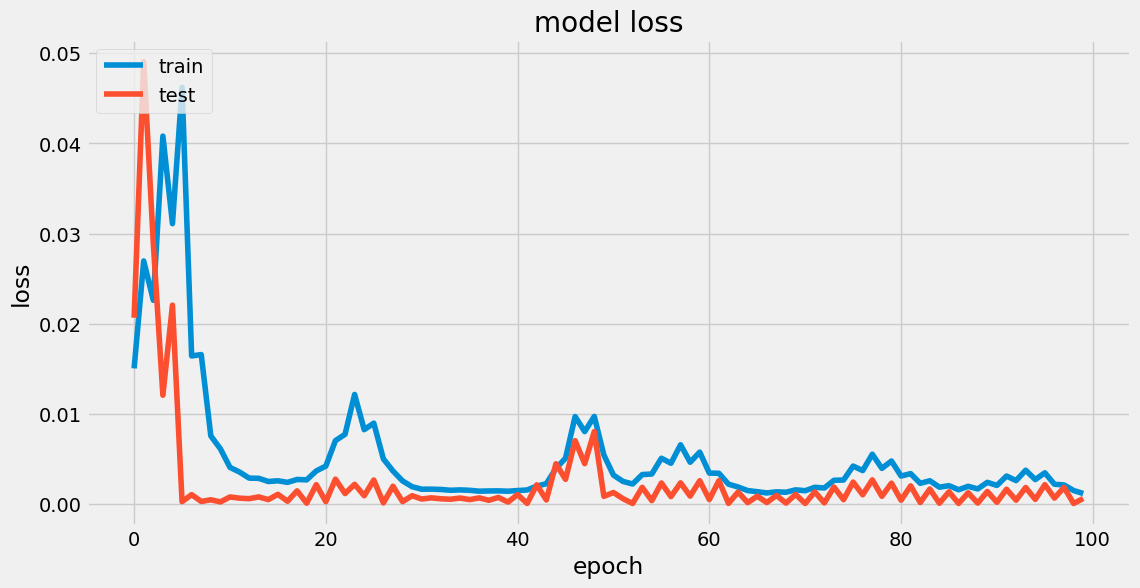

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step
(30, 1)


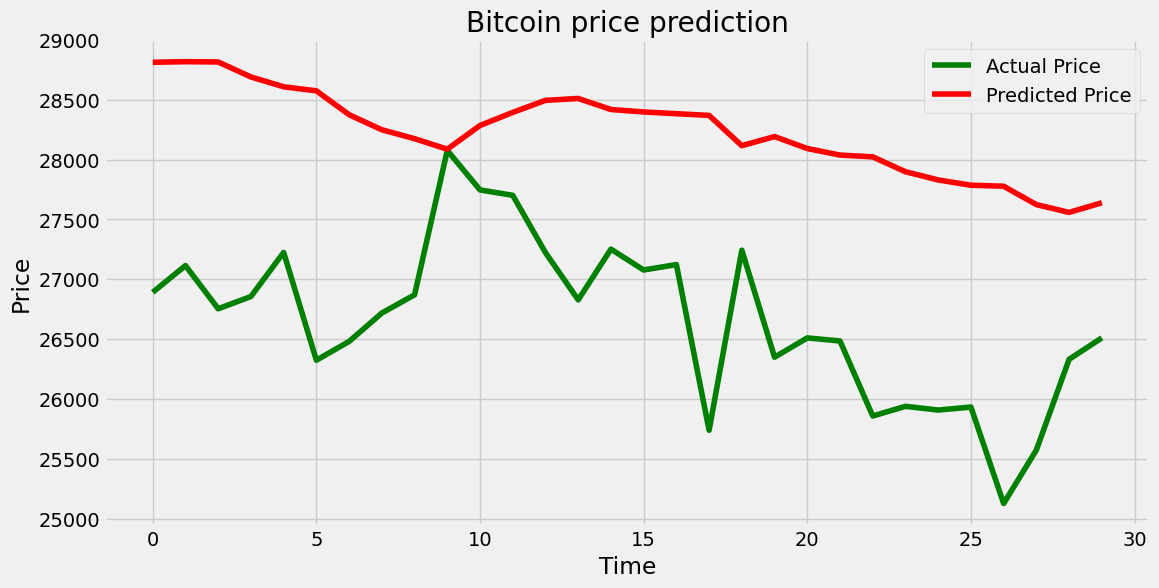

In [66]:
# Testing on entire data
y_hat = model.predict([X_test, X_test_Decoder])
# y_hat = y_hat.transpose(2,0,1).reshape(X_train_series_sub[0], -1)
print(y_hat.shape)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [67]:
def Accuracy(y_hat_inverse, y_test_inverse):
  diff = abs(y_hat_inverse - y_test_inverse)
  accuracy = 100 - (100 * (diff/y_test_inverse))
  accuracy = sum(accuracy)/len(accuracy)
  return accuracy


In [68]:
print("Accuracy of the Model: ",Accuracy(y_hat_inverse, y_test_inverse))

Accuracy of the Model:  [94.03827539]


In [ ]:
model.save('Bitcoin-Encoder-Decoder.h5')